total Dataset of val2017 is :  1
../s2am2//checkpoints/1e3_bs16_256_2017_rascv2/model_best.pth.tar ssim: 0.9864006811417484 psnr: 37.11598496120327 mse: 11.4903564453125 [1580]


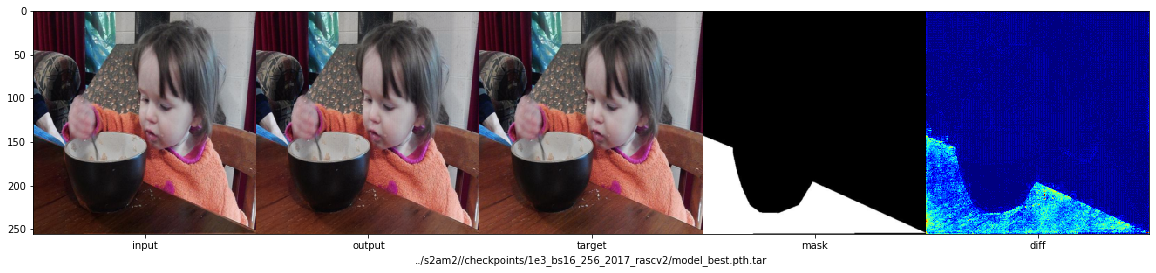

In [10]:
import os 
import torch
import numpy as np
from PIL import Image, ImageChops
from matplotlib import cm
import sys
import random

from scripts.utils.imutils import batch_with_heatmap,normalize_batch,im_to_numpy
import scripts.models as models
import scripts.datasets as datasets
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

class objectview(object):
    def __init__(self, *args, **kwargs):
        d = dict(*args, **kwargs)
        self.__dict__ = d
            
def get_jet():
    colormap_int = np.zeros((256, 3), np.uint8)
 
    for i in range(0, 256, 1):
        colormap_int[i, 0] = np.int_(np.round(cm.jet(i)[0] * 255.0))
        colormap_int[i, 1] = np.int_(np.round(cm.jet(i)[1] * 255.0))
        colormap_int[i, 2] = np.int_(np.round(cm.jet(i)[2] * 255.0))

    return colormap_int

jet_map = get_jet()

def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

def gray2color(gray_array, color_map):
    
    rows, cols = gray_array.shape
    color_array = np.zeros((rows, cols, 3), np.uint8)
 
    for i in range(0, rows):
        for j in range(0, cols):
#             log(256,2) = 8 , log(1,2) = 0 * 8
            color_array[i, j] = color_map[clamp(int(abs(gray_array[i, j])*10),0,255)]
    
    return color_array


dataset_name= 'val2017'
dataroot = '../s2am2/'
model_dir = '../s2am2//checkpoints/1e3_bs16_256_2017_rascv2/model_best.pth.tar'

sample = random.sample(range(1700), 1)


data_config  = objectview({'input_size':256,'limited_dataset':0, 'normalized_input':False,'data_augumentation':False,'base_dir':dataroot,'data':dataset_name})
val_loader = torch.utils.data.DataLoader(datasets.COCO('',args=data_config,sample=sample),
                                     batch_size=1, shuffle=False,
                                     num_workers=2, pin_memory=False)

checkpoint_dict = torch.load(model_dir,map_location=torch.device('cpu'))
checkpoint = checkpoint_dict['state_dict']
model = models.__dict__['rascv2']()
model.load_state_dict(checkpoint)
model.eval()

with torch.no_grad():
    for i, (inputs, target,name_of_img) in enumerate(val_loader):            
        inputs = inputs
        mask = inputs[:,3:4,:,:]

        output = model(inputs)

        inputsnp = (im_to_numpy(inputs[0,0:3])*255).clip(0,255).astype(np.uint8)
        outputnp = (im_to_numpy(output[0])*255).clip(0,255).astype(np.uint8)
        targetnp = (im_to_numpy(target[0])*255).astype(np.uint8)


        targetnp = (im_to_numpy(target[0])*255).clip(0,255).astype(np.uint8)
        masknp = (im_to_numpy(inputs[0,3:4].repeat(3,1,1))*255).clip(0,255).astype(np.uint8)

        tmp_ssim = ssim(targetnp,outputnp,multichannel=True)
        tmp_psnr = psnr(targetnp,outputnp)
        tmp_mse = np.mean( (outputnp - targetnp) ** 2 )

        print(model_dir,'ssim:',tmp_ssim,'psnr:',tmp_psnr,'mse:',tmp_mse,sample)

        im_output = Image.fromarray(outputnp)
        im_input = Image.fromarray(inputsnp)
        im_target = Image.fromarray(targetnp)
        im_mask = Image.fromarray(masknp)

        jetnp = gray2color(np.array(ImageChops.difference(im_target,im_output).convert('L')),jet_map)
        im_jet = Image.fromarray(jetnp)


        plt.figure(figsize=(20,5))
        plt.xlabel(model_dir)
        plt.imshow(np.concatenate((inputsnp,outputnp,targetnp,masknp,jetnp),axis=1))
        plt.xticks(128+np.arange(5)*256,['input','output','target','mask','diff'] )
            